In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import remove_outliers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


# 2.0 EDA

## Data preparation/cleaning

In [ ]:
df = pd.read_csv('../lab/data/cardio_train.csv', index_col=0)
df.head()

In [ ]:
# no missing values
df.info()

In [ ]:
# age recalculated from days to years
df['age'] = df['age']/365

In [ ]:
# change ome col names
df = df.rename(columns={'ap_hi': 'systolic_high', 'ap_lo': 'diastolic_low', 'gluc': 'glucose', 'alco': 'alcohol', 'cardio': 'cardio_disease'})

In [ ]:
# check values in columns containing cathegorical values
df["gender"].value_counts(), df["cholesterol"].value_counts(), df[
    "glucose"
].value_counts(), df["smoke"].value_counts(), df["alcohol"].value_counts(), df[
    "active"
].value_counts(), df[
    "cardio_disease"
].value_counts()

#-----------------------------------------------------------------------------------
# all seem ok

In [ ]:
# check reasonalbility of columns containing non-cathegorical values
df.describe()

#-----------------------------------------------------------------------------------------
# age - reasonable
# hight - very low and very high values present (most humans can be assumed to be between 145-200 cm)
# weight - too low values present (consideing min age is 26 years, reasonable with margins 30 and above)
# systolic_high - too low and too high values present (reasonable with margins between 50 - 250)
# diastolic_low - too low and too high values present (reasonable with margins between 20 - 180)

In [ ]:
# visualizing all data
fig, axes = plt.subplots(2,2, figsize = (16,8))
y_cols = ['height', 'weight', 'systolic_high', 'diastolic_low']

# axes.faltten creates a list-like object ([axes[0][0], axes[0][1], axes[1][0], axes[1][1]], ....)
for ax, y_col in zip(axes.flatten(), y_cols):
    sns.scatterplot(data=df, x=df.index, y= y_col, ax = ax)

Height:
* values below 100 are suspected to be typos where 100-s was missed. can not be sure, thus remove those datapoints
* most humas should be between 145-200 cm thus remove datapoints which are not between 125-220 cm

Weight:
* values below 30 are removed

Systolic_high:
* keep values 50-250

Diastolic_low
* keep values 20-180

In [ ]:
# removing rows with datapoints which are not physically feasable
df = df.query(
    "height >= 125 & height <= 220 & weight >= 30 & systolic_high <= 250 & systolic_high >= 50 & diastolic_low <= 180 & diastolic_low >= 20"
)

In [ ]:
# visualizing cleaned data

fig, axes = plt.subplots(2,2, figsize = (16,8))
y_cols = ['height', 'weight', 'systolic_high', 'diastolic_low']

for ax, y_col in zip(axes.flatten(), y_cols):
    sns.scatterplot(data=df, x=df.index, y= y_col, ax = ax)

In [ ]:
df.info()

#-------------------------------------
# while cleaning data 1298 points were removed

### a) How many are positive and how many are negative for cardio-vascular disease?
34699 negative, 34003 positive

In [ ]:
df['cardio_disease'].value_counts()

### b). What are fractions of people with 1: normal, 2: above normal, 3: well above normal cholesterol?

In [ ]:
df['cholesterol'].value_counts()

In [ ]:
plt.pie(df['cholesterol'].value_counts(), autopct='%.0f%%', labels=['normal cholesterol', 'above normal', 'well above normal']);
plt.title('Fractions of people with 3 levels of cholesterol');

### c) Plot histogram over age distribution

In [ ]:
sns.displot(df, x='age').set(title = 'Age distribution');

### d) What percentage smokes?
8.8 % smoke

In [ ]:
100 * (df['smoke'].sum()/len(df))

### e) Plot weight distribution

In [ ]:
sns.histplot(df, x='weight', bins=40).set(title = 'Weight distribution');

### f) Plot height distribution

In [ ]:
sns.histplot(df, x='height', bins=40).set(title = 'Height distribution');

### g) What percentage of women and men have cardiovascular desease?
49 % of women, 50 % of men

In [ ]:
percentage_women = 100 * len(df.query('gender == 1 & cardio_disease == 1'))/len(df.query('gender == 1'))
percentage_women

In [ ]:
percentage_men = 100 * len(df.query('gender == 2 & cardio_disease == 1'))/len(df.query('gender == 2'))
percentage_men

In [ ]:
df_women = df[df['gender'] == 1]
plt.pie(df_women['cardio_disease'].value_counts(), autopct='%.1f%%', labels=['healthy', 'with cardio-vascular disease']);
plt.title('Women');


In [ ]:
df_men = df[df['gender'] == 2]
plt.pie(df_men['cardio_disease'].value_counts(), autopct='%.1f%%', labels=['healthy', 'with cardio-vascular disease']);
plt.title('Men');

# 2.1.0 Feature engineering BMI

### Create BMI feature

In [ ]:
df['BMI'] = df['weight']/(0.0001 * df['height'] * df['height'])
df.head()

### a) Clean BMI column from outliers and not reasonable values
Min and max thresholds for BMI according to theory are < 16.0 and >= 40, thus BMI in our data far from these can probably be considered ouliers. For a more stringent approach Tukeys rule can be used, where outliers can be visulaized with boxplot. In our data removing ouliers accoring to Tukeys rule results in BMI_min = 14.5 and BMI_max = 39.5, which is in the same range as theoretical cut-offs.

In [ ]:
# scatterplott and corresponding boxplot of all BMI i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'BMI', ax=ax[0]);
sns.boxplot(data=df, x="BMI", ax=ax[1]);
fig.suptitle('BMI in dataset prior to removal of ouliers')

In [ ]:
df = remove_outliers(df, 'BMI')

In [ ]:
df['BMI'].min(), df['BMI'].max()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'BMI', ax=ax[0]);
sns.boxplot(data=df, x="BMI", ax=ax[1]);
fig.suptitle('BMI in dataset after removal of ouliers')

### b) Create a categorical BMI feature
|Category          |threshold      | index |
|-------------------|---------------|-------|
|Underweight (Thin) |	< 18.5      |1      |
|Normal range    	|18.5 – 24.9    |2     |
|Overweight     	|25.0 – 29.9    |3     |
|Obesity (Class 1)	|30.0 – 34.9    |4      |
|Obesity (Class 2)	|35.0 – 39.9    |5    |
| Obesity (Class 3)	|≥ 40.0         |6      |

In [ ]:
def categorize_BMI(BMI):
    if BMI < 18.5:
        return 1
    if BMI >= 18.5 and BMI < 25:
        return 2
    if BMI >= 25 and BMI < 30:
        return 3
    if BMI >= 30 and BMI < 35:
        return 4
    if BMI >= 35 and BMI < 40:
        return 5
    if BMI >= 40:
        return 6

In [ ]:
df['BMI_category'] = df['BMI'].apply(categorize_BMI)
df.head()

# 2.1.1 Feature engineering blood pressure

### Systolic pressure - removing outliers
Min and max thresholds for systolic blood pressure according to referenced article are < 120 mmHg and > 180 mmHg. After removing outliers using Tukeys rule systolic bloodpressure values in dataset were between 93 - 169 mmHg, which is reasonably close to min/max thresholds. Possibly some points at high end should not have been removed.

In [ ]:
# scatterplott and corresponding boxplot of all systolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'systolic_high', ax=ax[0]);
sns.boxplot(data=df, x="systolic_high", ax=ax[1]);
fig.suptitle('Systolic pressure in dataset prior to removal of ouliers')

In [ ]:
df = remove_outliers(df, 'systolic_high')

In [ ]:
df['systolic_high'].min(), df['systolic_high'].max()

In [ ]:
# scatterplott and corresponding boxplot of all systolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'systolic_high', ax=ax[0]);
sns.boxplot(data=df, x="systolic_high", ax=ax[1]);
fig.suptitle('Systolic pressure in dataset after removal of ouliers')

### Diastolic pressure - removing outliers
Min and max thresholds for diastolic blood pressure according to referenced article are < 80 mmHg and > 120 mmHg. After removing outliers using Tukeys rule diastolic bloodpressure values in dataset were between 66 - 104 mmHg, which is reasonably close to min/max thresholds. Possibly some points at high end should not have been removed.

In [ ]:
# scatterplott and corresponding boxplot of all diastolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'diastolic_low', ax=ax[0]);
sns.boxplot(data=df, x="diastolic_low", ax=ax[1]);
fig.suptitle('Diastolic pressure in dataset prior to removal of ouliers')

In [ ]:
df = remove_outliers(df, 'diastolic_low')

In [ ]:
df['diastolic_low'].min(), df['diastolic_low'].max()

In [ ]:
# scatterplott and corresponding boxplot of all diastolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'diastolic_low', ax=ax[0]);
sns.boxplot(data=df, x="diastolic_low", ax=ax[1]);
fig.suptitle('Diastolic pressure in dataset after removal of ouliers')

Final dataset after outlier removal contains 61910 samples out of the original 70000.

### Create a categorical blood pressure feature

|Category               | index  |
|-------------------    |------- |
|Healthy                |1       |
|Elevated          	    |2       |
|Stage 1 hypertension   |3       |
|Stage 2 hypertension	|4       |


thresholds according to table https://www.healthline.com/health/high-blood-pressure-hypertension#symptoms

In [ ]:
def categorize_blood_pressure(systolic, diastolic):
    """Categorizes blood pressure 1-4 depending on systolic and diastolic pressures"""
    if  systolic < 120 and diastolic < 80:
        return 1
    if  systolic >= 120 and systolic <130 and diastolic < 80:
        return 2
    if  systolic >= 130 and systolic <140 or diastolic >= 80 and diastolic < 90:
        return 3
    if  systolic >= 140 or diastolic >= 90:
        return 4

In [ ]:
new_col = df.apply(lambda row: categorize_blood_pressure(row['systolic_high'], row['diastolic_low']), axis = 1)
df.insert(loc = 6, column='blood_pressure_category', value=new_col)

In [ ]:
df.head()

# 2.2.0 Visualisation - percentage disease

In [ ]:
columns = ['BMI_category','blood_pressure_category', 'cholesterol','glucose', 'smoke', 'alcohol', 'active', 'gender']

fig, axes = plt.subplots(2, 4, figsize = (14,8), sharey=True)
fig.text(0.07, 0.5,'fraction with cardio disease', va='center', rotation='vertical')
plt.subplots_adjust(hspace=0.3)

for ax, column in zip(axes.flatten(), columns):
    sns.barplot(df, x= column, y='cardio_disease', ax=ax).set(ylabel = None)

# 2.2.1 Visualisation - correlation
Strong correlation can be seen between BMI - BMI_category - weight, all of each are dependant on eachother <br>
Strong correlation can also be seen between systolic - diastolic - blood pressure category which are dependant on eachother <br>
There is a correlation between systolic and diastolic blood pressures <br>
Onset of disease seems to be moslty correlated to systolic blood pressure followed by diastolic blood pressure, age, BMI. However all of which are weak.

In [ ]:
fig = plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True)

# 2.3 Create 2 datasets

In [ ]:
df_1 = df.drop(columns=['systolic_high', 'diastolic_low', 'height', 'weight', 'BMI'])
df_1 = pd.get_dummies(data=df_1, columns=['BMI_category', 'blood_pressure_category', 'gender'], drop_first=True)
df_1.head(3)

In [ ]:
df_2 = df.drop(columns=['BMI_category', 'blood_pressure_category', 'height', 'weight'])
df_2 = pd.get_dummies(data=df_2, columns=['gender'], drop_first= True)
df_2.head(3)

# 2.4 Choose model
Following models are evaluated for both datasets:
* logisic regression
* KNN classifier
* SVM classifier
* random forrest

cv = 5 will be used for all model training, which is a common choice<br>
scoring = 'recall' as metric since we want to minimize false negative responses as dataset is to be used for diagnostics

---

#### train|val|test split (df_1) - 60|20|20

In [78]:
X1, y1 = df_1.drop(columns='cardio_disease'), df_1['cardio_disease']
X1.shape, y1.shape

((61910, 14), (61910,))

In [79]:
X1_trainval, X1_test, y1_trainval, y1_test = train_test_split(X1, y1, test_size=0.20)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_trainval, y1_trainval, test_size=0.25)

X1_train.shape, X1_val.shape, X1_test.shape, y1_train.shape, y1_val.shape, y1_test.shape

((37146, 14), (12382, 14), (12382, 14), (37146,), (12382,), (12382,))

#### scaling data (df_1)
Choosing feature standardisation. MinMax scaler could have been evaluated too, but it is not done within the scope of this project

In [132]:
scaler = StandardScaler()

scaled_X1_train = scaler.fit_transform(X1_train)
scaled_X1_val = scaler.transform(X1_val)

#### Logistic regression - df_1

In [145]:
# Parameter tuning of hyperparameters: 'l1-ratio', 'C'
# 1st round: param_grid = {"l1_ratio": np.linspace(0, 1, 20), "C": [0.1, 1, 10, 100]} -> 0 (thus Ridge indicated by l2), 1
# 2nd round: param_grid = {"l1_ratio": [0, 0.1], "C": [0.5, 0.6, 0.7, 0.8, 0.9] - > 0, 0.8

param_grid = {"l1_ratio": [0, 0.1], "C": [0.5, 0.6, 0.7, 0.8, 0.9]} 
model_1_lr = GridSearchCV(LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000), param_grid=param_grid, cv=5, scoring="recall")
model_1_lr.fit(scaled_X1_train, y1_train)
model_1_lr.best_params_

{'C': 0.8, 'l1_ratio': 0}

In [148]:
# train model with chosen parameters: l1-ratio = 0 (<=> penalty = l2), C = 0.8
# calculate scores for model on train and val data

model_1_lr = LogisticRegression(penalty = 'l2', solver='lbfgs', max_iter=10000, C=0.8)
model_1_lr.fit(scaled_X1_train, y1_train)
y1_pred_lr = model_1_lr.predict(scaled_X1_val)

print(f'Score train: {100 * model_1_lr.score(scaled_X1_train, y1_train):.2f} %')
print(f'Score val: {100 * model_1_lr.score(scaled_X1_val, y1_val):.2f} %')

Score train: 69.35 %
Score val: 69.19 %


#### KNN neighbors - df_1

In [155]:
# Parameter tuning of hyperparameter: n_neighbors
# 1st round: param_grid = {"n_neighbors": range(1,30)} -> 17

param_grid = {"n_neighbors": range(1,30)} 
model_1_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring="recall")
model_1_knn.fit(scaled_X1_train, y1_train)
model_1_knn.best_params_

{'n_neighbors': 17}

In [156]:
# train model with chosen parameter: n_neighbors = 17
# calculate scores for model on train and val data

model_1_knn = KNeighborsClassifier(n_neighbors=17)
model_1_knn.fit(scaled_X1_train, y1_train)
y1_pred_knn = model_1_knn.predict(scaled_X1_val)

print(f'Score train: {100 * model_1_knn.score(scaled_X1_train, y1_train):.2f} %')
print(f'Score val: {100 * model_1_knn.score(scaled_X1_val, y1_val):.2f} %')

Score train: 71.52 %
Score val: 67.64 %


#### SVM - df_1

In [159]:
# Parameter tuning of hyperparameters: C, kernel
# 1st round: param_grid = {"C": [0.1, 1, 10], "kernel": ['linear', 'poly', 'rbf', 'sigmoid']} -> 10, rbf
# could finetune C but since calculations take long time it will not be done in this lavb

# param_grid = {"C": [0.1, 1, 10], "kernel": ['linear', 'poly', 'rbf', 'sigmoid']} 
# model_1_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=1, scoring="recall")
# model_1_svm.fit(scaled_X1_train, y1_train)
# model_1_svm.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'C': 10, 'kernel': 'rbf'}

In [161]:
# train model with chosen parameter: C = 10, kernel = rbf
# calculate scores for model on train and val data

model_1_svm = SVC(C=10, kernel="rbf")
model_1_svm.fit(scaled_X1_train, y1_train)
y1_pred_svm = model_1_svm.predict(scaled_X1_val)

print(f"Score train: {100 * model_1_svm.score(scaled_X1_train, y1_train):.2f} %")
print(f"Score val: {100 * model_1_svm.score(scaled_X1_val, y1_val):.2f} %")


Score train: 70.74 %
Score val: 69.05 %


#### Random forrest - df_1

In [ ]:
# scaling not required

In [96]:
# Parameter tuning of hyperparameters: n_estimators, max_depth
# Fixed criterion = 'gini', max_features = sqrt
# 1st round: param_grid = {"n_estimators": [100, 150, 200, 300], "max_depth": [5, 10, 15, 20]} -> 300, 10
# 2nd tuning: param_grid = {"n_estimators": [300, 350], "max_depth": [10]} -> 300, 10

param_grid = {"n_estimators": [300, 350], "max_depth": [10]} 
model_1_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, verbose=1, scoring="recall")
model_1_rf.fit(X1_train, y1_train)
model_1_rf.best_params_


Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'max_depth': 10, 'n_estimators': 300}

In [120]:
# train model with chosen parameters: 'max_depth': 10, 'n_estimators': 300 and calculate scores for model on train and val data
model_1_rf = RandomForestClassifier(n_estimators=300, max_depth=10)
model_1_rf.fit(X1_train, y1_train)
y1_pred_rf = model_1_rf.predict(X1_val)

print(f'Score train: {100 * model_1_rf.score(X1_train, y1_train):.2f} %')
print(f'Score val: {100 * model_1_rf.score(X1_val, y1_val):.2f} %')

Score train: 71.48 %
Score val: 69.21 %


---
#### train|val|test split (df_2) - 60|20|20

In [81]:
# df_2
X2, y2 = df_2.drop(columns='cardio_disease'), df_2['cardio_disease']
X2.shape, y2.shape

((61910, 10), (61910,))

In [82]:
X2_trainval, X2_test, y2_trainval, y2_test = train_test_split(X2, y2, test_size=0.20)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_trainval, y2_trainval, test_size=0.25)

X2_train.shape, X2_val.shape, X2_test.shape, y2_train.shape, y2_val.shape, y2_test.shape

((37146, 10), (12382, 10), (12382, 10), (37146,), (12382,), (12382,))

#### scaling data (df_2)
Choosing feature standardisation. MinMax scaler could have been evaluated too, but it is not done within the scope of this project

In [130]:
scaler = StandardScaler()

scaled_X2_train = scaler.fit_transform(X2_train)
scaled_X2_val = scaler.transform(X2_val)

#### Logistic regression - df_2

In [149]:
# Parameter tuning of hyperparameters: 'l1-ratio', 'C'
# 1st round: param_grid = {"l1_ratio": np.linspace(0, 1, 20), "C": [0.1, 1, 10, 100]} -> 0.42, 0.1
# 2nd round: param_grid = {"l1_ratio": [0.3, 0.4, 0.5], "C": [0.01, 0.05, 0.1, 0.15] - > 0.4, 0.1

param_grid = {"l1_ratio": [0.3, 0.4, 0.5], "C": [0.01, 0.05, 0.1, 0.15]}
model_2_lr = GridSearchCV(LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000), param_grid=param_grid, cv=5, scoring="recall")
model_2_lr.fit(scaled_X2_train, y2_train)
model_2_lr.best_params_

{'C': 0.1, 'l1_ratio': 0.4}

In [151]:
# train model with chosen parameters: l1-ratio = 0.42, C = 0.1
# calculate scores for model on train and val data

model_2_lr = LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000, C=0.1, l1_ratio=0.42)
model_2_lr.fit(scaled_X2_train, y2_train)
y2_pred_lr = model_2_lr.predict(scaled_X2_val)

print(f'Score train: {100 * model_2_lr.score(scaled_X2_train, y2_train):.2f} %')
print(f'Score val: {100 * model_2_lr.score(scaled_X2_val, y2_val):.2f} %')

Score train: 72.08 %
Score val: 71.79 %


#### KNN neighbors - df_2

In [157]:
# Parameter tuning of hyperparameter: n_neighbors
# 1st round: param_grid = {"n_neighbors": range(1,30)} -> 15

param_grid = {"n_neighbors": range(1,30)} 
model_2_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring="recall")
model_2_knn.fit(scaled_X2_train, y2_train)
model_2_knn.best_params_

{'n_neighbors': 15}

In [158]:
# train model with chosen parameter: n_neighbors = 15
# calculate scores for model on train and val data

model_2_knn = KNeighborsClassifier(n_neighbors=15)
model_2_knn.fit(scaled_X2_train, y2_train)
y2_pred_knn = model_2_knn.predict(scaled_X2_val)

print(f'Score train: {100 * model_2_knn.score(scaled_X2_train, y2_train):.2f} %')
print(f'Score val: {100 * model_2_knn.score(scaled_X2_val, y2_val):.2f} %')

Score train: 74.45 %
Score val: 71.36 %


#### SVM - df_2

In [160]:
# Parameter tuning of hyperparameters: C, kernel
# 1st round: param_grid = {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']} -> 0.1, rbf

param_grid = {"C": [0.1, 1, 10], "kernel": ['linear','rbf']} 
model_2_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=5, verbose=1, scoring="recall")
model_2_svm.fit(scaled_X2_train, y2_train)
model_2_svm.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'C': 0.1, 'kernel': 'rbf'}

In [162]:
# train model with chosen parameter: C=.1, kernel = rbf
# calculate scores for model on train and val data

model_2_svm = SVC(C=0.1, kernel='rbf')
model_2_svm.fit(scaled_X2_train, y2_train)
y2_pred_svm = model_2_svm.predict(scaled_X2_val)

print(f'Score train: {100 * model_2_svm.score(scaled_X2_train, y2_train):.2f} %')
print(f'Score val: {100 * model_2_svm.score(scaled_X2_val, y2_val):.2f} %')

Score train: 72.66 %
Score val: 72.44 %


#### Random forrest - df_2

In [ ]:
# scaling not needed

In [183]:
# Parameter tuning of hyperparameters: n_estimators, max_depth
# Fixed criterion = 'gini', max_features = sqrt
# 1st round: param_grid = {"n_estimators": [100, 200, 300, 400], "max_depth": [5, 10, 15, 20]} -> 300, 15
# 2nd tuning: param_grid = {"n_estimators": [10, 100, 200, 300], "max_depth": [15]} -> 100, 15
# 3rd tuning: param_grid = {"n_estimators": [10, 50, 100, 150], "max_depth": [15]}  -> 100, 15

param_grid = {"n_estimators": [10, 50, 100, 150], "max_depth": [15]} 
model_2_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, verbose=1, scoring="recall")
model_2_rf.fit(X2_train, y2_train)
model_2_rf.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'max_depth': 15, 'n_estimators': 100}

In [186]:
# train model with chosen parameter: n_estimators=100, max_depth=15
# calculate scores for model on train and val data

model_2_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
model_2_rf.fit(X2_train, y2_train)
y2_pred_rf = model_2_rf.predict(X2_val)

print(f'Score train: {100 * model_2_rf.score(X2_train, y2_train):.2f} %')
print(f'Score val: {100 * model_2_rf.score(X2_val, y2_val):.2f} %')

Score train: 82.20 %
Score val: 72.50 %


#### Summary of scores from all models:
|model          | dataset       |score - train  |score - val    |
|---------------|---------------|---------------|---------------|
|logistic reg   |df_1           |69.35 %        |69.19 %        |
|KNN            |df_1           |71.52 %        |67.64 %        |
|SVM            |df_1           |70.74 %        |69.05 %        |
|random forrest |df_1           |71.48 %        |69.12 %        |
|logistic reg   |df_2           |72.08 %        |71.79 %        |
|KNN            |df_2           |74.45 %        |71.36 %        |
|SVM            |df_2           |72.66 %        |72.44 %        |
|random forrest |df_2           |82.20 %        |72.50 %        |

Conlusions:
* all tested models result in similar (relatively poor) scores
* score for train data and val data are similar in all cases indicating models are not overfitted (random forrest df2 possibly exception)
* df_2 results generally in somewhat higher scores indicating that having acual values for featuras rather than categorizing them is advantegous
* SVM least prefered choice since time consuming and not better than others
* logistic regression by far fastest and relatively good result
* KNN and random forrest similar in calculation time

Choice: df_2 and ranom forrest since reasonable calculation time and somewhat better result

---
#### Training random forrest on df_2 train and val

In [195]:
# scaling not needed

# training on train and val data
model_trainval_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
model_trainval_rf.fit(X2_trainval, y2_trainval)
y2_trainval_pred_rf = model_trainval_rf.predict(X2_test)

# printing scores for trainval och test data
print(f'Score trainval: {100 * model_trainval_rf.score(X2_trainval, y2_trainval):.2f} %')
print(f'Score test: {100 * model_trainval_rf.score(X2_test, y2_test):.2f} %')

Score trainval: 80.96 %
Score test: 72.85 %


# 2.5 Ensamble

In [194]:
# scaling of data
scaler = StandardScaler()
scaled_X2_trainval = scaler.fit_transform(X2_trainval)
scaled_X2_test = scaler.transform(X2_test)

In [196]:
# listing modles to be included in voting (svm omitted to save calculation times)
classifier_lg = LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000, C=0.1, l1_ratio=0.42)
classifier_knn = KNeighborsClassifier(n_neighbors=15)
classifier_rf = RandomForestClassifier(n_estimators=100, max_depth=15)

# creating voting model with hard voting, training it and makeing a prediction
model_vc = VotingClassifier(estimators=[('lg', classifier_lg), ('knn', classifier_knn), ('rf', classifier_rf)], voting = 'hard')
model_vc = model_vc.fit(scaled_X2_trainval, y2_trainval)
y2_trainval_pred_vc = model_vc.predict(scaled_X2_test)

#printing scores for trainval och test data
print(f'Score trainval: {100 * model_vc.score(scaled_X2_trainval, y2_trainval):.2f} %')
print(f'Score test: {100 * model_vc.score(scaled_X2_test, y2_test):.2f} %')

Score trainval: 76.53 %
Score test: 72.82 %


# 2.6 Evaluation

### Random forrest model

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6279
           1       0.75      0.68      0.71      6103

    accuracy                           0.73     12382
   macro avg       0.73      0.73      0.73     12382
weighted avg       0.73      0.73      0.73     12382



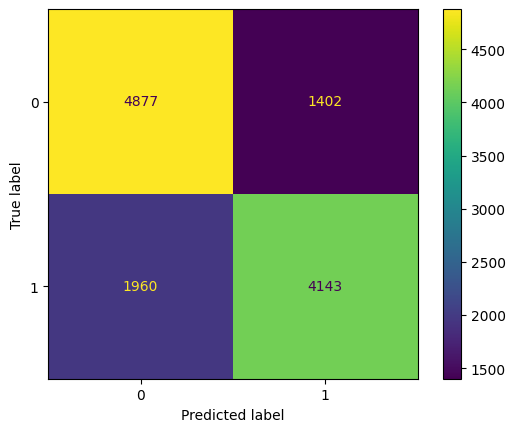

In [204]:
# classification report
print(classification_report(y2_test, y2_trainval_pred_rf))

# confusion matix
cm = confusion_matrix(y2_test, y2_trainval_pred_rf)
ConfusionMatrixDisplay(cm).plot();

### Voting classifier model

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6279
           1       0.75      0.67      0.71      6103

    accuracy                           0.73     12382
   macro avg       0.73      0.73      0.73     12382
weighted avg       0.73      0.73      0.73     12382



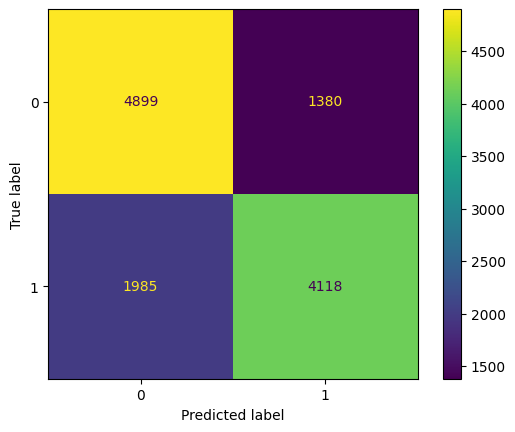

In [203]:
# classification report
print(classification_report(y2_test, y2_trainval_pred_vc))

# confusion matix
cm = confusion_matrix(y2_test, y2_trainval_pred_vc)
ConfusionMatrixDisplay(cm).plot();

# 2.7 "Deploy" model

#### pick 100 samples from main dataframe and save as .csv

In [221]:
# crating a copy of df_2 not to make changes in the original fram
df_61910 = df_2

# pick 100 random samples from df_2_copy and save as cv file
df_100 = df_61910.sample(n=100)
df_100.to_csv('../lab/data/test_samples.csv')

# remove those 100 samples from the large dataframe
df_61810 = df_61910.drop(df_100.index)

# check that 100 rows have been removed
len(df_61910) - len(df_61810)

100

#### train best model on remaining dataframe

In [222]:
# split dataframe into X (features) and y (target)
X_df_61810, y_df_61810 = df_61810.drop('cardio_disease', axis='columns'), df_61810['cardio_disease']
X_df_61810.shape, y_df_61810.shape

((61810, 10), (61810,))

In [223]:
# scaling not needed for Random Forrest

# training on full dataframe minus the 100 samples
model_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
model_rf.fit(X_df_61810, y_df_61810)

RandomForestClassifier(max_depth=15)

In [228]:
# saving model
joblib.dump(model_rf, 'model_rf.pkl')

['model_rf.pkl']